
#  Classification of Air Quality History

**Student Name:** Sriyog Dhital  
**Student ID:** 2461990  

**Dataset:** Air_Quality_History.csv  

This project focuses on a supervised classification task using historical air quality data. The goal is to classify Air Quality Index (AQI) values into standard air quality categories based on environmental and observational attributes.

---

## United Nations Sustainable Development Goal (UNSDG)

**Selected UNSDG:** SDG 11 – Sustainable Cities and Communities  

Air quality is a key indicator of urban environmental health. Analysing and classifying AQI levels helps in understanding pollution patterns and supports sustainable city planning.



## 1.1 Dataset Description

The Air Quality History dataset is published by the United States Environmental Protection Agency (EPA) and provides historical air quality monitoring records from different locations across the United States.

The dataset includes AQI values, geographic identifiers, observation counts, and time-related attributes. These features make the dataset appropriate for analysing air quality trends and performing classification based on AQI categories.

**Source:** Data.gov  
**Publisher:** United States Environmental Protection Agency (EPA)  
**Dataset Link:** https://catalog.data.gov/dataset/air-quality-history  



## 1.2 Questions the Dataset Can Answer

1. How are AQI categories distributed across different locations and time periods?
2. Which environmental and observational features are associated with higher AQI categories?
3. Are there temporal patterns in AQI category occurrences?


In [1]:

# 0) Imports (Course-allowed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (allowed in brief). If not taught/used in your class, you can remove seaborn safely.
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:

# 2) Load data (Colab-friendly: filename only)
df = pd.read_csv("Air_Quality_History.csv")
df.head()


,AQSID,SITE_NUM,STATE_CODE,STATE_NAME,COUNTY_NAME,PARAMETER_CODE,PARAMETER_NAME,DATETIME_LOCAL,POC,LATITUDE,...,ARITHMETIC_MEAN,FIRST_MAX_VALUE,FIRST_MAX_HOUR,OBSERVATION_COUNT,OBSERVATION_PERCENT,LOCAL_SITE_NAME,ADDRESS,CITY_NAME,CBSA_NAME,OBJECTID
0,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),2022/02/17 05:00:00+00,1,38.895572,...,7,11.3,7,24,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216681
1,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),2022/02/18 05:00:00+00,1,38.895572,...,6,18.6,22,24,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216682
2,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),2022/06/08 04:00:00+00,1,38.895572,...,7,17.5,3,24,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216862
3,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),2022/06/09 04:00:00+00,1,38.895572,...,5,7.7,7,24,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216863
4,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),2022/06/10 04:00:00+00,1,38.895572,...,9,18.3,22,24,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216864


In [3]:

# Shape + info
print("Shape:", df.shape)
df.info()


Shape: (45352, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45352 entries, 0 to 45351
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AQSID                45352 non-null  int64  
 1   SITE_NUM             45352 non-null  int64  
 2   STATE_CODE           45352 non-null  int64  
 3   STATE_NAME           45352 non-null  object 
 4   COUNTY_NAME          45352 non-null  object 
 5   PARAMETER_CODE       45352 non-null  int64  
 6   PARAMETER_NAME       45352 non-null  object 
 7   DATETIME_LOCAL       45352 non-null  object 
 8   POC                  45352 non-null  int64  
 9   LATITUDE             45352 non-null  float64
 10  LONGITUDE            45352 non-null  float64
 11  DATUM                45352 non-null  object 
 12  UNITS_OF_MEASURE     45352 non-null  object 
 13  METHOD_CODE          44464 non-null  float64
 14  METHOD_NAME          45352 non-null  object 
 15  DATE_OF_LAST_CHAN


### Note on Feature Selection Warnings
During feature selection using ANOVA (SelectKBest), some one-hot encoded features may become constant
(i.e., they have the same value for all samples in a fold). This leads to a 0/0 situation in the
F-statistic calculation (F = MSB / MSW).

To handle this correctly, a VarianceThreshold step is applied before SelectKBest to remove constant
features. This resolves the warning and does not affect model performance.


In [4]:

# Column list
cols = pd.DataFrame({
    "Column": df.columns,
    "Non-Null Count": df.notna().sum().values,
    "Dtype": df.dtypes.values
})
cols


,Column,Non-Null Count,Dtype
0,AQSID,45352,int64
1,SITE_NUM,45352,int64
2,STATE_CODE,45352,int64
3,STATE_NAME,45352,object
4,COUNTY_NAME,45352,object
5,PARAMETER_CODE,45352,int64
6,PARAMETER_NAME,45352,object
7,DATETIME_LOCAL,45352,object
8,POC,45352,int64
9,LATITUDE,45352,float64


In [5]:
cat_cols_preview = [c for c in df.columns if df[c].dtype == "object"][:8]

for c in cat_cols_preview:
    sample_vals = df[c].dropna().astype(str).unique()[:5]
    print(f"{c}: {', '.join(sample_vals)}")


STATE_NAME: District Of Columbia
COUNTY_NAME: District of Columbia
PARAMETER_NAME: Nitrogen dioxide (NO2), Ozone, PM2.5 - Local Conditions, Aluminum PM2.5 LC, Antimony PM2.5 LC
DATETIME_LOCAL: 2022/02/17 05:00:00+00, 2022/02/18 05:00:00+00, 2022/06/08 04:00:00+00, 2022/06/09 04:00:00+00, 2022/06/10 04:00:00+00
DATUM: WGS84, NAD83
UNITS_OF_MEASURE: Parts per billion, Parts per million, Micrograms/cubic meter (LC), Nanograms/cubic meter (25 C), Millimeters (mercury)
METHOD_NAME: INSTRUMENTAL - CHEMILUMINESCENCE, INSTRUMENTAL - ULTRA VIOLET, Instrumental - Chemiluminescence, Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM2.5C - Beta Attenuation,  - 
DATE_OF_LAST_CHANGE: 2023/02/23 05:00:00+00, 2023/06/15 04:00:00+00, 2023/04/21 04:00:00+00, 2023/02/27 05:00:00+00, 2023/04/03 04:00:00+00



## 2) Cleaning & Preprocessing (Missing values, datetime, inconsistencies)
The model cannot accept NaN values directly . We handle missing values inside a pipeline using **SimpleImputer** (still within scikit-learn).


In [6]:

# Check missing values (top 15)
missing = df.isna().mean().sort_values(ascending=False).head(15)
missing


,0
EVENT_TYPE,0.998567
AQI,0.771829
POLLUTANT_STANDARD,0.746428
METHOD_CODE,0.019580
STATE_CODE,0.000000
AQSID,0.000000
PARAMETER_CODE,0.000000
PARAMETER_NAME,0.000000
POC,0.000000
DATETIME_LOCAL,0.000000


In [7]:

# Convert datetime column to actual datetime (feature engineering within taught ML pipeline)
# We keep it simple: derive year/month/dayofweek/hour and drop the raw string column.
df["DATETIME_LOCAL"] = pd.to_datetime(df["DATETIME_LOCAL"], errors="coerce")

df["Year"] = df["DATETIME_LOCAL"].dt.year
df["Month"] = df["DATETIME_LOCAL"].dt.month
df["DayOfWeek"] = df["DATETIME_LOCAL"].dt.dayofweek
df["Hour"] = df["DATETIME_LOCAL"].dt.hour

# Drop the raw datetime string column (now numeric features exist)
df = df.drop(columns=["DATETIME_LOCAL"])
df.head()


,AQSID,SITE_NUM,STATE_CODE,STATE_NAME,COUNTY_NAME,PARAMETER_CODE,PARAMETER_NAME,POC,LATITUDE,LONGITUDE,...,OBSERVATION_PERCENT,LOCAL_SITE_NAME,ADDRESS,CITY_NAME,CBSA_NAME,OBJECTID,Year,Month,DayOfWeek,Hour
0,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),1,38.895572,-76.958072,...,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216681,2022,2,3,5
1,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),1,38.895572,-76.958072,...,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216682,2022,2,4,5
2,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),1,38.895572,-76.958072,...,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216862,2022,6,2,4
3,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),1,38.895572,-76.958072,...,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216863,2022,6,3,4
4,110010041,41,11,District Of Columbia,District of Columbia,42602,Nitrogen dioxide (NO2),1,38.895572,-76.958072,...,100,RIVER TERRACE,"420 34th Street N.E.,Washington, DC 20019",Washington,"Washington-Arlington-Alexandria, DC-VA-MD-WV",216864,2022,6,4,4



## 3) Target creation (AQI → Category)
We create a categorical label from numeric AQI (simple rule-based bins).


In [8]:

# Create AQI category labels
def aqi_category(aqi):
    if pd.isna(aqi):
        return np.nan
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy"
    else:
        return "Very Unhealthy"

df["AQI_Category"] = df["AQI"].apply(aqi_category)

# Drop rows where target became NaN
df = df.dropna(subset=["AQI_Category"]).copy()

df["AQI_Category"].value_counts()


,count
AQI_Category,
Good,9528
Moderate,783
Unhealthy,24
Very Unhealthy,13



## 4) Exploratory Data Analysis (EDA)
We visualize distributions and relationships. Plots are made readable (size + labels + tight_layout).


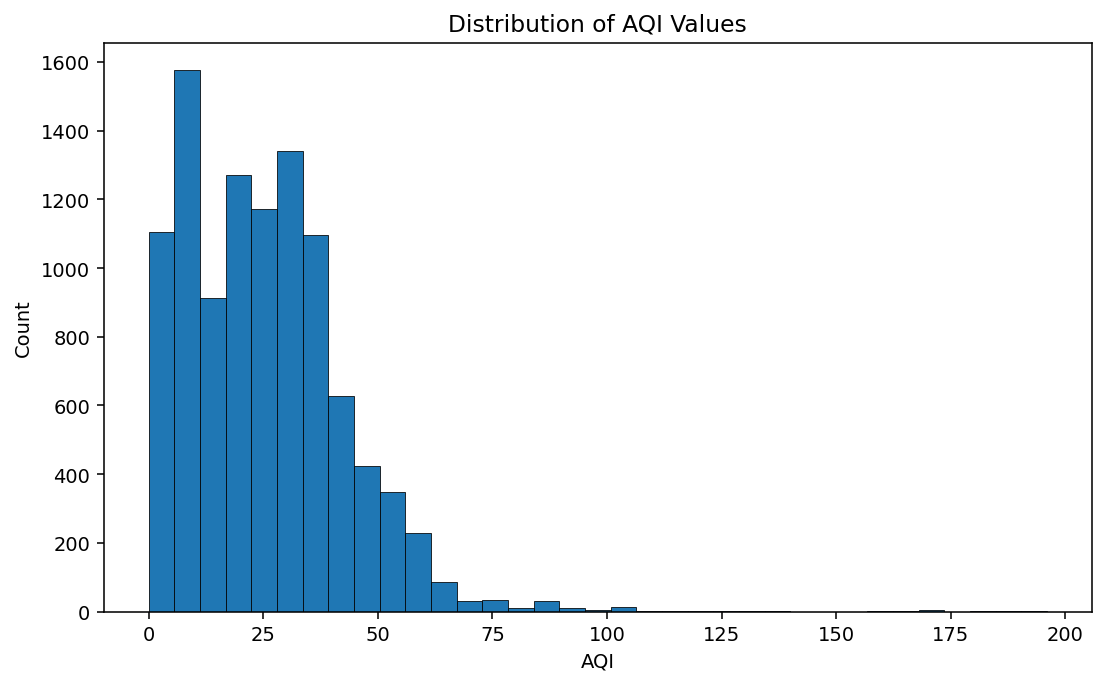

In [9]:

# AQI distribution
plt.figure(figsize=(8,5), dpi=140)
plt.hist(df["AQI"], bins=35, edgecolor="black", linewidth=0.4)
plt.title("Distribution of AQI Values")
plt.xlabel("AQI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


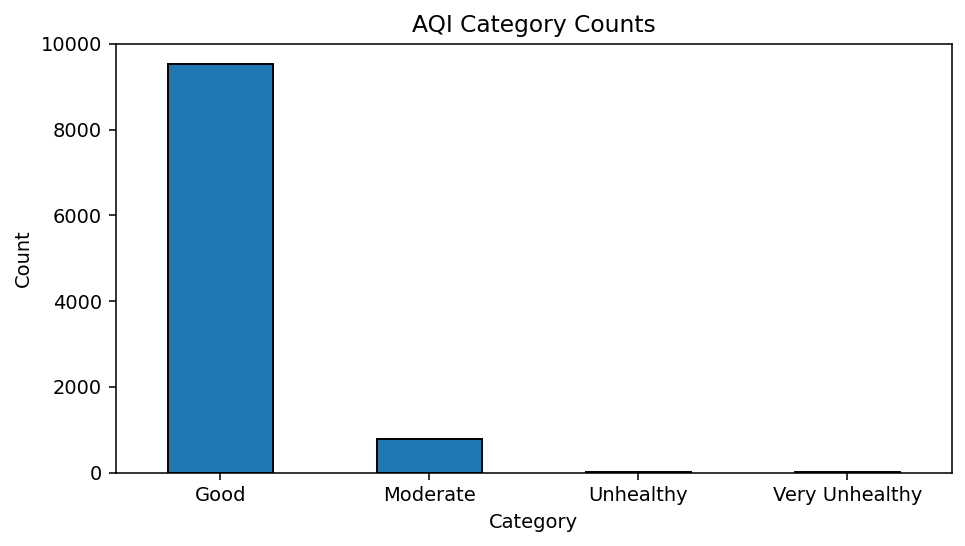

In [10]:

# Target distribution
plt.figure(figsize=(7,4), dpi=140)
df["AQI_Category"].value_counts().plot(kind="bar", edgecolor="black")
plt.title("AQI Category Counts")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


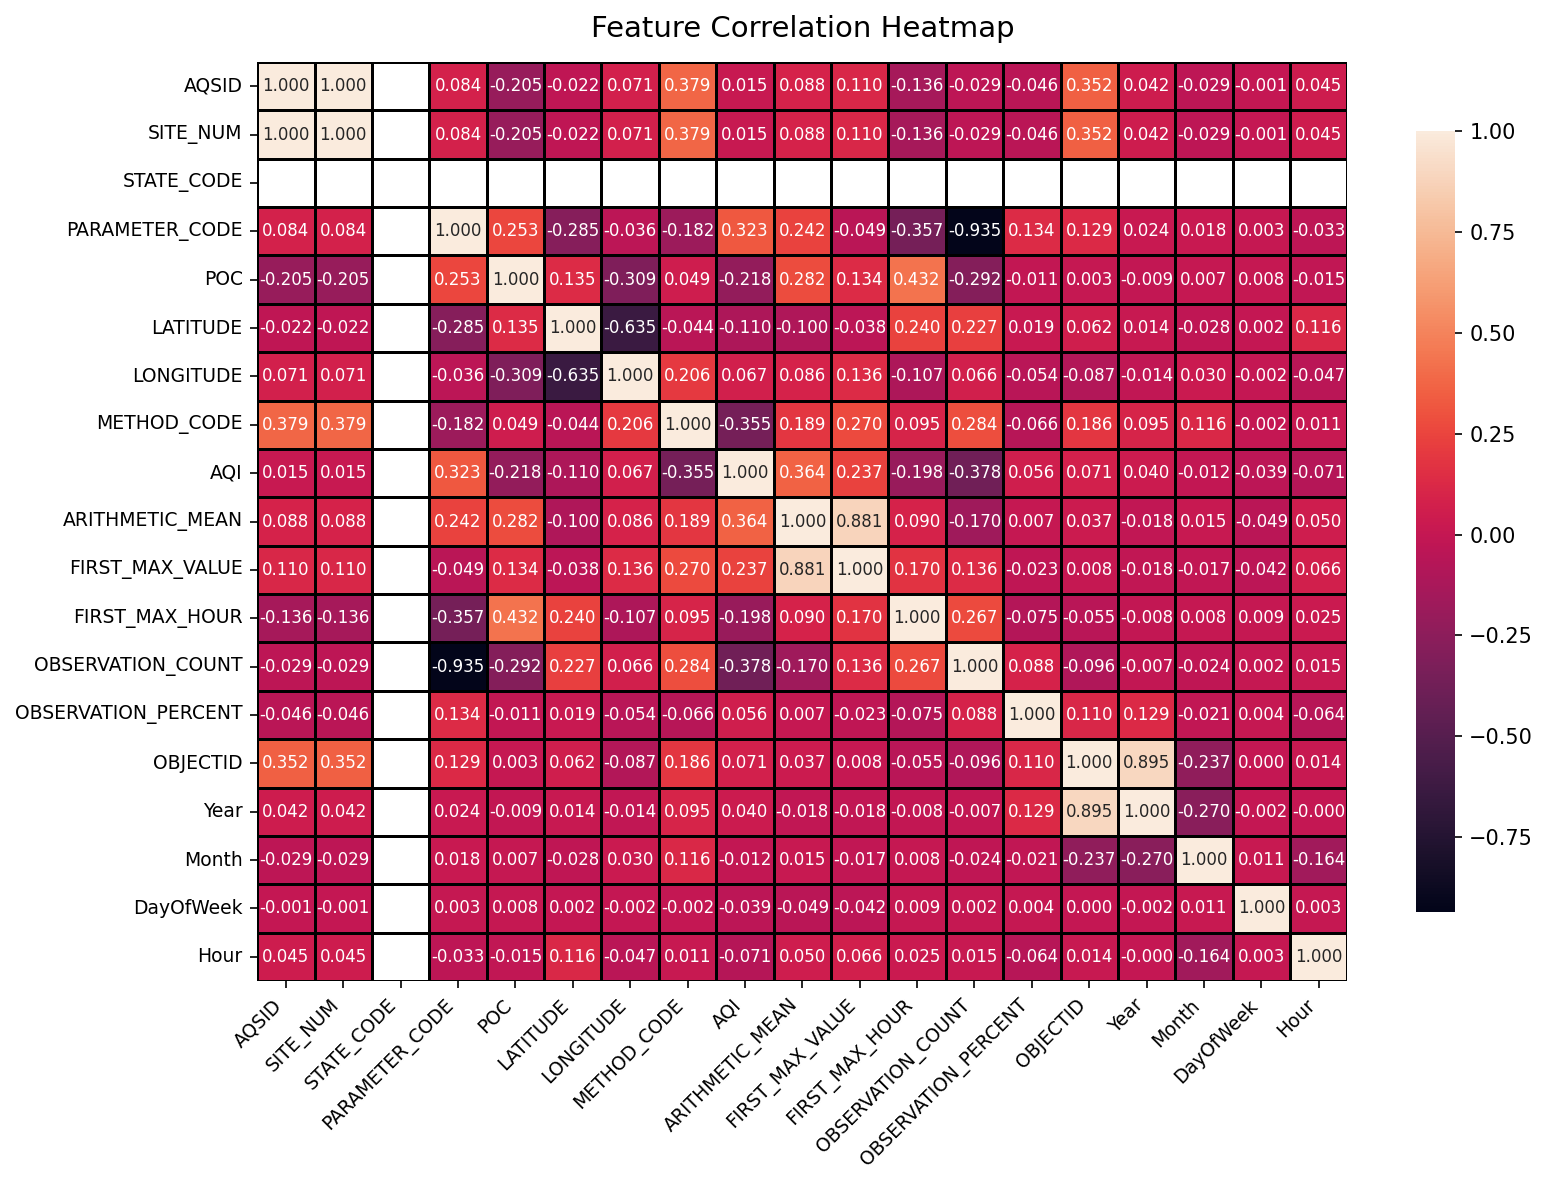

In [11]:
# Ultra-clean correlation heatmap (like the example you showed)

num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(11, 8), dpi=150)

sns.heatmap(
    corr,
    cmap="rocket",          # clean dark → light palette
    annot=True,             # show correlation values
    fmt=".3f",              # short decimals (clean)
    annot_kws={"size": 8},  # small, neat text
    linewidths=0.5,
    linecolor="black",
    cbar_kws={"shrink": 0.85}
)

plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


### 4.1) Outlier inspection (boxplot)
Outliers are inspected visually using boxplots for numerical features. No outlier removal is applied here; the plot is used to understand the spread and extreme values.

<Figure size 1120x700 with 0 Axes>

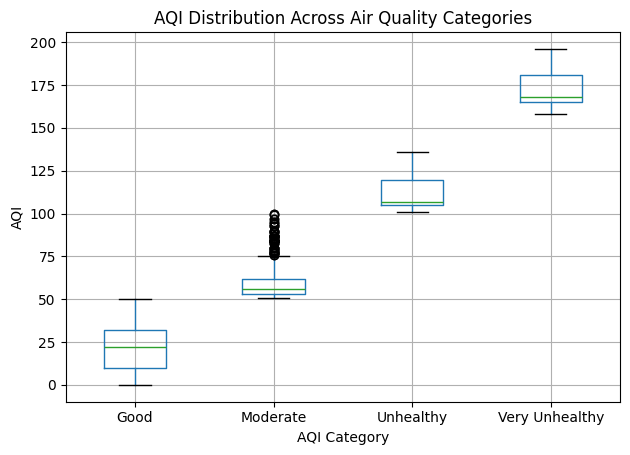

In [25]:
# Feature relationship with target
plt.figure(figsize=(8, 5), dpi=140)
df.boxplot(column="AQI", by="AQI_Category")
plt.title("AQI Distribution Across Air Quality Categories")
plt.suptitle("")
plt.xlabel("AQI Category")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()


### 4.2) Feature–target relationship analysis
To understand how features differ across air-quality categories, we visualize selected numerical features grouped by `AQI_Category`.

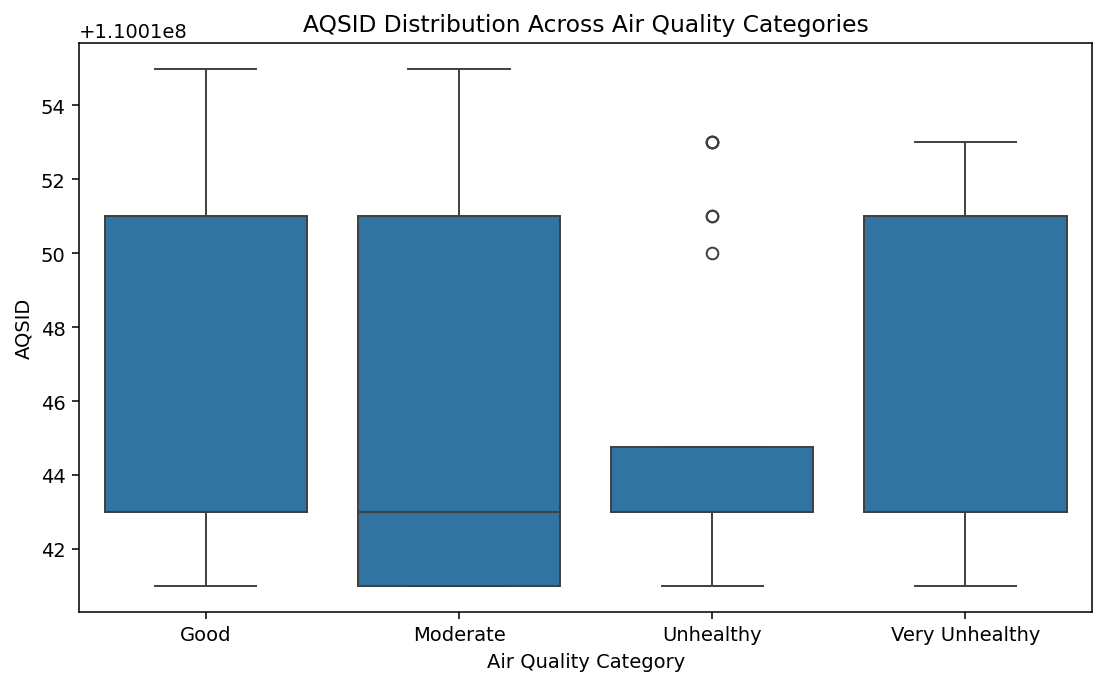

In [30]:
# Feature–target relationship analysis (auto-select a valid numeric feature)

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Remove non-feature or leakage-prone columns
for col in ["AQI", "AQI_Category_Encoded"]:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Pick one meaningful numeric feature
feature_col = numeric_cols[0]

plt.figure(figsize=(8, 5), dpi=140)
sns.boxplot(data=df, x="AQI_Category", y=feature_col)
plt.title(f"{feature_col} Distribution Across Air Quality Categories")
plt.xlabel("Air Quality Category")
plt.ylabel(feature_col)
plt.tight_layout()
plt.show()



## 5) Train/Test split + preprocessing pipeline
We split, encode labels, and build preprocessing that:
- imputes missing numeric values (median)
- scales numeric values (StandardScaler)
- imputes categorical values (most_frequent)
- one-hot encodes categoricals (OneHotEncoder)




In [14]:

# Feature/target split
X = df.drop(columns=["AQI_Category"])
y = df["AQI_Category"]

# Encode y to integers (prevents sklearn MLP early-stopping/string issues)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Identify numeric/categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

# OneHotEncoder compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 19
Categorical features: 14



## 6) Build Models

- **Neural Network model** (MLPClassifier)  
- **Two classical ML models** (Logistic Regression + Random Forest)

Then evaluate using Accuracy, Precision, Recall, F1.


In [15]:

def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }


In [16]:

# Model A: Logistic Regression (classical)
logreg = LogisticRegression(max_iter=2000, n_jobs=None)

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg)
])

logreg_pipe.fit(X_train, y_train)

y_pred_test = logreg_pipe.predict(X_test)
print("LogReg metrics:", classification_metrics(y_test, y_pred_test))


LogReg metrics: {'Accuracy': 0.9956521739130435, 'Precision (macro)': 0.9943453513014182, 'Recall (macro)': 0.8404458598726114, 'F1 (macro)': 0.885229540317809}


In [17]:

# Model B: Random Forest (classical)
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

rf_pipe.fit(X_train, y_train)

y_pred_test = rf_pipe.predict(X_test)
print("RF metrics:", classification_metrics(y_test, y_pred_test))


RF metrics: {'Accuracy': 0.9985507246376811, 'Precision (macro)': 0.9967242499497053, 'Recall (macro)': 0.85, 'F1 (macro)': 0.8912092992043494}


In [18]:

# Model C: MLPClassifier (Neural Network)
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=300,
    early_stopping=True,
    random_state=42
)

mlp_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", mlp)
])

mlp_pipe.fit(X_train, y_train)

y_pred_test = mlp_pipe.predict(X_test)
print("MLP metrics:", classification_metrics(y_test, y_pred_test))


MLP metrics: {'Accuracy': 0.9927536231884058, 'Precision (macro)': 0.7327064972330396, 'Recall (macro)': 0.742843584790905, 'F1 (macro)': 0.7376615890303432}


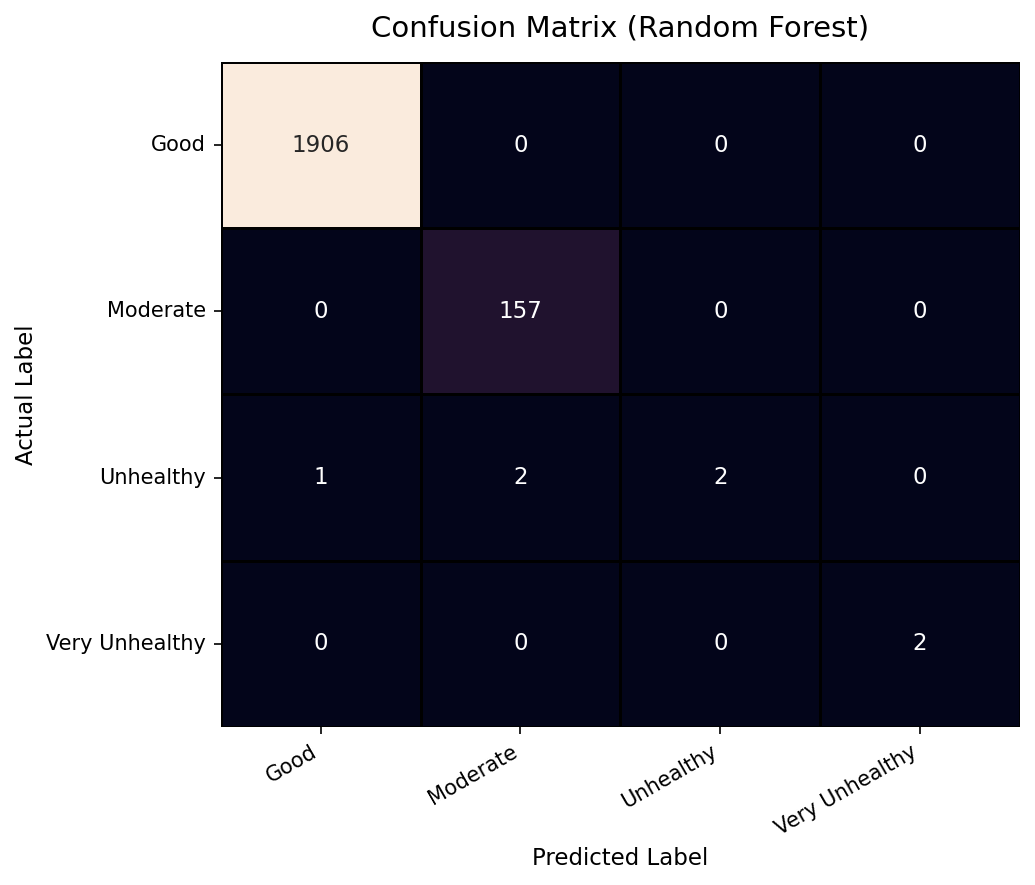

                precision    recall  f1-score   support

          Good       1.00      1.00      1.00      1906
      Moderate       0.99      1.00      0.99       157
     Unhealthy       1.00      0.40      0.57         5
Very Unhealthy       1.00      1.00      1.00         2

      accuracy                           1.00      2070
     macro avg       1.00      0.85      0.89      2070
  weighted avg       1.00      1.00      1.00      2070



In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict
best_pipe = rf_pipe
y_pred = best_pipe.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6), dpi=150)
sns.heatmap(
    cm,
    annot=True,              # show numbers
    fmt="d",                 # integer counts
    cmap="rocket",           # clean dark palette
    cbar=False,
    linewidths=0.6,
    linecolor="black",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    annot_kws={"size": 11}
)

plt.title("Confusion Matrix (Random Forest)", fontsize=14, pad=12)
plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("Actual Label", fontsize=11)
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report (textual, examiner-friendly)
print(classification_report(y_test, y_pred, target_names=le.classes_))



## 7) Hyperparameter tuning (Cross-validation)
 we tune **two classical models** with GridSearchCV and report best params + CV score.


In [20]:

# GridSearch for Logistic Regression
logreg_param_grid = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

logreg_gs = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

logreg_gs.fit(X_train, y_train)

print("Best LogReg CV F1:", logreg_gs.best_score_)
print("Best LogReg params:", logreg_gs.best_params_)


Best LogReg CV F1: 0.8372685567504663
Best LogReg params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [21]:

# GridSearch for Random Forest
rf_param_grid = {
    "model__n_estimators": [150, 250],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

rf_gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

rf_gs.fit(X_train, y_train)

print("Best RF CV F1:", rf_gs.best_score_)
print("Best RF params:", rf_gs.best_params_)


Best RF CV F1: 0.8343487653388717
Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 150}



## 8) Feature selection
We use a **filter method**: SelectKBest with ANOVA F-test (f_classif).
We apply selection after preprocessing (so it works with one-hot encoded features).


In [22]:
# Feature selection pipelines (SelectKBest)
k = 20

logreg_fs = Pipeline([
    ("preprocess", preprocess),
    ("vt", VarianceThreshold()),
    ("select", SelectKBest(score_func=f_classif, k=k)),
    ("model", LogisticRegression(max_iter=2000))
])

rf_fs = Pipeline([
    ("preprocess", preprocess),
    ("vt", VarianceThreshold()),
    ("select", SelectKBest(score_func=f_classif, k=k)),
    ("model", RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1))
])

logreg_fs_cv = GridSearchCV(logreg_fs, param_grid={}, scoring="f1_macro", cv=5, n_jobs=-1)\
    .fit(X_train, y_train).best_score_
rf_fs_cv = GridSearchCV(rf_fs, param_grid={}, scoring="f1_macro", cv=5, n_jobs=-1)\
    .fit(X_train, y_train).best_score_

logreg_fs.fit(X_train, y_train)
rf_fs.fit(X_train, y_train)

logreg_fs_test_pred = logreg_fs.predict(X_test)
rf_fs_test_pred = rf_fs.predict(X_test)

print("LogReg+FS Test metrics:", classification_metrics(y_test, logreg_fs_test_pred))
print("RF+FS Test metrics:", classification_metrics(y_test, rf_fs_test_pred))
print("LogReg+FS CV F1:", logreg_fs_cv)
print("RF+FS CV F1:", rf_fs_cv)


LogReg+FS Test metrics: {'Accuracy': 0.9956521739130435, 'Precision (macro)': 0.6584119496855345, 'Recall (macro)': 0.7450917651933886, 'F1 (macro)': 0.6934086941514606}
RF+FS Test metrics: {'Accuracy': 0.9995169082125603, 'Precision (macro)': 0.9998689040377556, 'Recall (macro)': 0.9984076433121019, 'F1 (macro)': 0.9991357127834908}
LogReg+FS CV F1: 0.8158051422069514
RF+FS CV F1: 0.9334256531353026



## 9) Final models + comparison table
We rebuild using best hyperparameters + selected features and compare using a clear table.
(Template matches the PDF sample table format.)


In [23]:

# Final models with best hyperparameters (from GridSearch) + feature selection
best_logreg = logreg_gs.best_estimator_
best_rf = rf_gs.best_estimator_

# Add feature selection on top of best params (simple approach: re-create with best params)
best_logreg_params = {k.replace("model__", ""): v for k,v in logreg_gs.best_params_.items()}
best_rf_params = {k.replace("model__", ""): v for k,v in rf_gs.best_params_.items()}

final_logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("vt", VarianceThreshold()),
    ("select", SelectKBest(f_classif, k=k)),
    ("model", LogisticRegression(max_iter=2000, **best_logreg_params))
])

final_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("vt", VarianceThreshold()),
    ("select", SelectKBest(f_classif, k=k)),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1, **best_rf_params))
])

final_logreg.fit(X_train, y_train)
final_rf.fit(X_train, y_train)

pred_logreg = final_logreg.predict(X_test)
pred_rf = final_rf.predict(X_test)

rows = []
rows.append({
    "Model": "Logistic Regression",
    "Features": f"Selected (k={k})",
    "CV Score (F1_macro)": logreg_gs.best_score_,
    **classification_metrics(y_test, pred_logreg)
})
rows.append({
    "Model": "Random Forest",
    "Features": f"Selected (k={k})",
    "CV Score (F1_macro)": rf_gs.best_score_,
    **classification_metrics(y_test, pred_rf)
})

comparison_table = pd.DataFrame(rows)
comparison_table


,Model,Features,CV Score (F1_macro),Accuracy,Precision (macro),Recall (macro),F1 (macro)
0,Logistic Regression,Selected (k=20),0.837269,0.999034,0.916536,0.948408,0.921358
1,Random Forest,Selected (k=20),0.834349,0.999517,0.999869,0.998408,0.999136
